In [179]:
import gensim
import gensim.downloader
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.metrics import mean_squared_error as mse
from tqdm.notebook import tqdm
from gensim.parsing.preprocessing import (
    preprocess_string,
    strip_tags,
    strip_punctuation,
    strip_multiple_whitespaces,
    strip_numeric
)

# Предобученный w2v (glove)

## Загрузка модели + векторизирование текста

In [180]:
list(gensim.downloader.info()['models'].keys())

['fasttext-wiki-news-subwords-300',
 'conceptnet-numberbatch-17-06-300',
 'word2vec-ruscorpora-300',
 'word2vec-google-news-300',
 'glove-wiki-gigaword-50',
 'glove-wiki-gigaword-100',
 'glove-wiki-gigaword-200',
 'glove-wiki-gigaword-300',
 'glove-twitter-25',
 'glove-twitter-50',
 'glove-twitter-100',
 'glove-twitter-200',
 '__testing_word2vec-matrix-synopsis']

In [181]:
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-50')

In [4]:
glove_vectors.most_similar('moscow')

[('kiev', 0.8409875631332397),
 ('prague', 0.8244465589523315),
 ('warsaw', 0.8230167031288147),
 ('russia', 0.820088803768158),
 ('russian', 0.8137035965919495),
 ('belgrade', 0.7946885228157043),
 ('berlin', 0.7849311232566833),
 ('minsk', 0.7801254987716675),
 ('kremlin', 0.7750862836837769),
 ('tehran', 0.7637045383453369)]

In [5]:
glove_vectors.word_vec('person')

array([ 0.61734  ,  0.40035  ,  0.067786 , -0.34263  ,  2.0647   ,
        0.60844  ,  0.32558  ,  0.3869   ,  0.36906  ,  0.16553  ,
        0.0065053, -0.075674 ,  0.57099  ,  0.17314  ,  1.0142   ,
       -0.49581  , -0.38152  ,  0.49255  , -0.16737  , -0.33948  ,
       -0.44405  ,  0.77543  ,  0.20935  ,  0.6007   ,  0.86649  ,
       -1.8923   , -0.37901  , -0.28044  ,  0.64214  , -0.23549  ,
        2.9358   , -0.086004 , -0.14327  , -0.50161  ,  0.25291  ,
       -0.065446 ,  0.60768  ,  0.13984  ,  0.018135 , -0.34877  ,
        0.039985 ,  0.07943  ,  0.39318  ,  1.0562   , -0.23624  ,
       -0.4194   , -0.35332  , -0.15234  ,  0.62158  ,  0.79257  ],
      dtype=float32)

In [188]:
with open('drive/MyDrive/Coursework2021/sticked_file.txt', 'r') as f:
    sentences = f.read().split('\n')
with open('drive/MyDrive/Coursework2021/big_eng_lstm_2000.txt', 'r') as f:
    sentences_g = f.read().split('\n')

In [189]:
# ПРЕПРОЦЕССИНГ ВЕКТОРОВ ДЛЯ ПРЕДЛОЖЕНИЙ РЕАЛЬНЫХ И ПРЕДЛОЖЕНИЙ СИНТЕТИЧЕСКИХ

preprocessing_funcs = [
    str.lower,
    strip_tags,
    strip_punctuation,
    strip_multiple_whitespaces,
    strip_numeric,
    # remove_stopwords,
]

words_in_data = []
embeddings = []
bad_words = []

words_in_data_g = []
embeddings_g = []
bad_words_g = []

for sentence in tqdm(sentences):
    words = preprocess_string(sentence, preprocessing_funcs)
    for word in words:
        try:
            embedding = glove_vectors.word_vec(word)
            embeddings.append(embedding)
            words_in_data.append(word)
        except KeyError:
            bad_words.append(word)
            embeddings.append(glove_vectors.word_vec('token'))
            # print(word, '\n', sentence, '\n\n')


for sentence in tqdm(sentences_g):
    words = preprocess_string(sentence, preprocessing_funcs)
    for word in words:
        try:
            embedding = glove_vectors.word_vec(word)
            embeddings_g.append(embedding)
            words_in_data.append(word)
        except KeyError:
            bad_words_g.append(word)
            embeddings_g.append(glove_vectors.word_vec('token'))
            # print(word, '\n', sentence, '\n\n')

In [190]:
print('ratio of bad words', len(bad_words) / len(embeddings), f'total {len(bad_words)} out of {len(embeddings)}')
print('ratio of bad words', len(bad_words_g) / len(embeddings_g), f'total {len(bad_words_g)} out of {len(embeddings_g)}')

ratio of bad words 0.009412442647965908 total 18098 out of 1922774
ratio of bad words 0.009976062671415365 total 16812 out of 1685234


In [195]:
np.save('drive/MyDrive/Coursework2021/glove_embeddings_real.npy', np.asarray(embeddings[:10**6]))
np.save('drive/MyDrive/Coursework2021/glove_embeddings_gen.npy', np.asarray(embeddings_g[:10**6]))

In [ ]:
train_words = words_in_data[10**6: 10**6 + 1_000_000]
train_embeddings = np.vstack(embeddings[10**6:10**6 + 1_000_000])
# np.save('drive/MyDrive/Coursework2021/glove_preptrain_train_embeddings.npy', train_embeddings)

In [ ]:
print(len(set(train_words)))
Counter(train_words).most_common(10)

18348


[('he', 117887),
 ('the', 49043),
 ('be', 40045),
 ('and', 29709),
 ('of', 25465),
 ('to', 23151),
 ('a', 21534),
 ('in', 14661),
 ('have', 14580),
 ('that', 10897)]

## Автоенкодер для GLOVE

In [104]:
from keras.layers import InputLayer, Dense
from keras.models import Model, Sequential

INPUT_DIM = 50
OUTPUT_DIM = 16
ACTIVATION = 'LeakyReLU'

encoder = Sequential([
    InputLayer(input_shape=(INPUT_DIM,)),
    Dense(OUTPUT_DIM, activation=ACTIVATION)
])
decoder = Sequential([
    InputLayer(input_shape=(OUTPUT_DIM,)),
    Dense(INPUT_DIM, activation=None)
])
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

In [107]:
h = autoencoder.fit(train_embeddings, train_embeddings, batch_size=16, epochs=6, verbose=True, validation_split=0.1)

print('testing')
encoded = autoencoder(np.vstack(embeddings[:10**6]))
print(mse(encoded, np.vstack(embeddings[:10**6])))

Epoch 1/6
51906/51906 [==============================] - 77s 1ms/step - loss: 0.0722 - val_loss: 0.0668
Epoch 2/6
51906/51906 [==============================] - 63s 1ms/step - loss: 0.0590 - val_loss: 0.0669
Epoch 3/6
 5471/51906 [==>...........................] - ETA: 52s - loss: 0.0584

KeyboardInterrupt: ignored

## Кластеризация сэмпла

### Класс Уишарта и его валидации

In [11]:
from collections import defaultdict
import scipy
import numpy as np
import sys

from itertools import  product
from scipy.special import gamma
from scipy.spatial.distance import  euclidean
from math import sqrt

from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KDTree

from sklearn.metrics import  silhouette_score, davies_bouldin_score, calinski_harabasz_score

import gc

def volume(r, m):
    return np.pi ** (m / 2) * r ** m / gamma(m / 2 + 1)

def significant(cluster, h, p):
    max_diff = max(abs(p[i] - p[j]) for i, j in product(cluster, cluster))

    # print(max_diff)
    return max_diff >= h


class WishartClusterization:
    def __init__(self, wishart_neighbors, significance_level):
        self.wishart_neighbors = wishart_neighbors  # Number of neighbors
        self.significance_level = significance_level  # Significance level

    def fit(self, X):
        kdt = KDTree(X, metric='euclidean')
        print('KDTree has been built')
        #add one because you are your neighb.
        distances, neighbors = kdt.query(X, k = self.wishart_neighbors + 1, return_distance = True)
        neighbors = neighbors[:, 1:]


        distances = distances[:, -1]
        print('distances')
        print(' '.join(list(map(str, distances))))


        indexes = np.argsort(distances)
        print('indexes sorted')
        print(' '.join(list(map(str, indexes))))

        size, dim = X.shape

        self.object_labels = np.zeros(size, dtype = int) - 1

        #index in tuple
        #min_dist, max_dist, flag_to_significant
        self.clusters = np.array([(1., 1., 0)])
        self.clusters_to_objects = defaultdict(list)
        #print('Start clustering')
        counter_to_print = 0
        for index in indexes:

            if counter_to_print % 100000 == 0:
                print(counter_to_print)
                print(' '.join(list(map(str, self.object_labels))), flush=True)

            counter_to_print += 1

            neighbors_clusters =\
                np.concatenate([self.object_labels[neighbors[index]], self.object_labels[neighbors[index]]])
            unique_clusters = np.unique(neighbors_clusters).astype(int)
            unique_clusters = unique_clusters[unique_clusters != -1]


            if len(unique_clusters) == 0:
                self._create_new_cluster(index, distances[index])
            else:
                max_cluster = unique_clusters[-1]
                min_cluster = unique_clusters[0]
                if max_cluster == min_cluster:
                    if self.clusters[max_cluster][-1] < 0.5:
                        self._add_elem_to_exist_cluster(index, distances[index], max_cluster)
                    else:
                        self._add_elem_to_noise(index)
                else:
                    my_clusters = self.clusters[unique_clusters]
                    flags = my_clusters[:, -1]
                    if np.min(flags) > 0.5:
                        self._add_elem_to_noise(index)
                    else:
                        significan = np.power(my_clusters[:, 0], -dim) - np.power(my_clusters[:, 1], -dim)
                        significan *= self.wishart_neighbors
                        significan /= size
                        significan /= np.power(np.pi, dim / 2)
                        significan *= gamma(dim / 2 + 1)
                        significan_index = significan >= self.significance_level

                        significan_clusters = unique_clusters[significan_index]
                        not_significan_clusters = unique_clusters[~significan_index]
                        significan_clusters_count = len(significan_clusters)
                        if significan_clusters_count > 1 or min_cluster == 0:
                            self._add_elem_to_noise(index)
                            self.clusters[significan_clusters, -1] = 1
                            for not_sig_cluster in not_significan_clusters:
                                if not_sig_cluster == 0:
                                    continue

                                for bad_index in self.clusters_to_objects[not_sig_cluster]:
                                    self._add_elem_to_noise(bad_index)
                                self.clusters_to_objects[not_sig_cluster].clear()
                        else:
                            for cur_cluster in unique_clusters:
                                if cur_cluster == min_cluster:
                                    continue

                                for bad_index in self.clusters_to_objects[cur_cluster]:
                                    self._add_elem_to_exist_cluster(bad_index, distances[bad_index], min_cluster)
                                self.clusters_to_objects[cur_cluster].clear()

                            self._add_elem_to_exist_cluster(index, distances[index], min_cluster)
        self.labels_ = self.clean_data()
        return self.labels_

    def clean_data(self):
        unique = np.unique(self.object_labels)
        index = np.argsort(unique)
        if unique[0] != 0:
            index += 1
        true_cluster = {unq :  index for unq, index in zip(unique, index)}
        result = np.zeros(len(self.object_labels), dtype = int)
        for index, unq in enumerate(self.object_labels):
            result[index] = true_cluster[unq]
        return result

    def _add_elem_to_noise(self, index):
        self.object_labels[index] = 0
        self.clusters_to_objects[0].append(index)

    def _create_new_cluster(self, index, dist):
        self.object_labels[index] = len(self.clusters)
        self.clusters_to_objects[len(self.clusters)].append(index)
        self.clusters = np.append(self.clusters, [(dist, dist, 0)], axis = 0)

    def _add_elem_to_exist_cluster(self, index, dist, cluster_label):
        self.object_labels[index] = cluster_label
        self.clusters_to_objects[cluster_label].append(index)
        self.clusters[cluster_label][0] = min(self.clusters[cluster_label][0], dist)
        self.clusters[cluster_label][1] = max(self.clusters[cluster_label][1], dist)

In [12]:
!git clone https://github.com/jqmviegas/jqm_cvi.git
!wget https://raw.githubusercontent.com/iphysresearch/S_Dbw_validity_index/master/S_Dbw.py

fatal: destination path 'jqm_cvi' already exists and is not an empty directory.
--2021-06-01 20:35:10--  https://raw.githubusercontent.com/iphysresearch/S_Dbw_validity_index/master/S_Dbw.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4235 (4.1K) [text/plain]
Saving to: ‘S_Dbw.py.2’

S_Dbw.py.2          100%[===================>]   4.14K  --.-KB/s    in 0s      

2021-06-01 20:35:10 (44.7 MB/s) - ‘S_Dbw.py.2’ saved [4235/4235]



In [162]:
import numpy as np
import pandas as pd

from scipy.spatial.distance import pdist, squareform
from scipy.special import gamma
from collections import defaultdict

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from itertools import cycle, islice
import seaborn as sns
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score
from jqm_cvi.jqmcvi import base
from S_Dbw import S_Dbw
from sklearn.neighbors import NearestNeighbors

# utils
def volume(r, dim):
    """
    Helper function to calculate volumes of a dim-dimensional spheres with radiuses r
    param r: radiuses of a spheres of shape (n_samples,): ndarray
    param dim: dimensionality of a sphere: int

    Returns:
        volumes: ndarray
    """
    dim_const = (np.pi ** (dim / 2)) / gamma(dim / 2 + 1)
    return dim_const * (r ** dim)


def significant(cluster, h, p):
    """
    Helper function to tell if a cluster is significant
    param cluster: vertices in cluster (indexed): list
    h: height hyperparameter: double
    p: estimated saliency for all points
    """
    p_cluster = p[np.array(cluster)]
    pw_difference = np.abs(p_cluster[:, np.newaxis] - p_cluster)
    max_diff = pw_difference.max()

    # print(max_diff)
    return max_diff >= h


class ClusterValidation:
    def __init__(self, data, labels, dist='euclidean'):
        """
        @param data: ndarray of shape (n_samples, n_features)
        @param labels: ndarray of shape (n_samples,), cluster labels for each sample
        @param dist: distance metric to use: str or callable; defaults to 'euclidean'
        """
        self.data = data
        self.labels = labels
        self.dist = dist
        self.num_cluster = labels.max() + 1
        self.cluster_list = list(range(self.num_cluster))

    def RMSSTD(self):
        dof = self.data.shape[0] - self.num_cluster
        n_features = self.data.shape[1]
        result = 0
        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            center = cluster_data.mean(axis=0)
            result += ((cluster_data - center) ** 2).sum()

        return (result / (dof * n_features)) ** (1 / 2)

    def RS(self):
        all_mean = ((self.data - self.data.mean(axis=0)) ** 2).sum()
        part_mean = 0

        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            center = cluster_data.mean(axis=0)
            part_mean += ((cluster_data - center) ** 2).sum()

        return (all_mean - part_mean) / all_mean

    def hubert(self):
        dist_matrix = squareform(pdist(self.data, self.dist))
        n = self.data.shape[0]

        centers = np.empty((self.num_cluster, self.data.shape[1]))
        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            center = cluster_data.mean(axis=0)
            centers[cluster] = center
        center_dist = squareform(pdist(centers, self.dist))

        result = 0
        for i in range(n):
            for j in range(n):
                result += (dist_matrix[i, j] * center_dist[self.labels[i], self.labels[j]])
        return (result * 2) / (n * (n-1)) 

    def CH(self):
        return calinski_harabasz_score(self.data, self.labels)

    def I_index(self):
        all_mean = np.sqrt(((self.data - self.data.mean(axis=0)) ** 2).sum())
        part_mean = 0
        centers = np.empty((self.num_cluster, self.data.shape[1]))

        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            center = cluster_data.mean(axis=0)
            centers[cluster] = center
            part_mean += np.sqrt(((cluster_data - center) ** 2).sum())
        center_dist = squareform(pdist(centers, self.dist))

        max_center_dist = center_dist.max()

        return (all_mean * max_center_dist) / (self.num_cluster * part_mean)

    def dunn(self):
        return base.dunn_fast(self.data, self.labels)

    def silhouette(self):
        return silhouette_score(self.data, self.labels)

    def davies_bouldin(self):
        return davies_bouldin_score(self.data, self.labels)

    def xie_beni(self):
        n = self.data.shape[0]
        part_mean = 0

        centers = np.empty((self.num_cluster, self.data.shape[1]))
        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            center = cluster_data.mean(axis=0)
            centers[cluster] = center
            part_mean += ((cluster_data - center) ** 2).sum()
        center_dist = squareform(pdist(centers, self.dist))

        center_dist = center_dist + np.diag(np.full_like(center_dist[0], center_dist.max()))

        return part_mean / (n * (center_dist.min()**2))

    def SD(self):
        scat, dis = 0, 0

        all_var_vector = np.var(self.data, 0)
        all_var = np.sqrt(np.sum(all_var_vector ** 2))
        part_var = 0

        centers = np.empty((self.num_cluster, self.data.shape[1]))
        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            center = cluster_data.mean(axis=0)
            centers[cluster] = center
            part_var_vector = np.var(cluster_data, 0)
            part_var += np.sqrt((part_var_vector ** 2).sum())
        center_dist = squareform(pdist(centers, self.dist))

        scat = part_var / (all_var * self.num_cluster)

        max_dist = center_dist.max()
        min_dist = (center_dist + np.diag(np.full_like(center_dist[0], max_dist))).min()
        sum_dist = np.sum(1.0 / np.sum(center_dist, axis=1))

        dis = (max_dist * sum_dist) / min_dist

        return scat + dis

    def S_Dbw(self):
        centers = np.empty((self.num_cluster, self.data.shape[1]))
        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            center = cluster_data.mean(axis=0)
            centers[cluster] = center

        sdbw = S_Dbw(self.data, self.labels, centers)
        return sdbw.S_Dbw_result()

    def CVNN(self, n_neighbors=10):
        com = 0
        sep = []
        neigh = NearestNeighbors(n_neighbors=n_neighbors)
        neigh.fit(self.data)
        knbrs = neigh.kneighbors(return_distance=False)

        for cluster in self.cluster_list:
            cluster_data = self.data[self.labels == cluster, :]
            cluster_ind = np.arange(self.data.shape[0])[self.labels == cluster]
            n_i = cluster_data.shape[0]
            if (n_i > 1):
                com += np.sum(pdist(cluster_data, metric=self.dist)) * 2 / (n_i * (n_i-1))
            sep.append(np.isin(knbrs[cluster_ind], cluster_ind, invert=True).sum() / (n_i * n_neighbors))

        sep = np.max(sep)

        return com + sep

    def run_all(self, n_neighbors=10, calc_hubert=True):
        results = {}
        results['rmsstd'] = self.RMSSTD()
        results['r-squared'] = self.RS()
        if calc_hubert:
            results['hubert'] = self.hubert()
        results['ch_index'] = self.CH()
        results['i_index'] = self.I_index()
        try:
            results['dunn'] = self.dunn()
        except ValueError as e:
            print('dunn failed with')
            print(e)
            results['dunn'] = np.nan
        results['silhouette'] = self.silhouette()
        results['davies_bouldin'] = self.davies_bouldin()
        results['xie_beni'] = self.xie_beni()
        results['sd'] = self.SD()
        try:
            results['s_dbw'] = self.S_Dbw()
        except:
            results['s_dbw'] = np.nan
        results['cvnn'] = self.CVNN(n_neighbors)

        return results


In [169]:
from scipy.stats import ranksums, kstest, ks_2samp
from scipy.spatial.distance import cdist

def cluster_mean_intracluster(X, y):
    mean_intracluster_dist = []
    for cluster_id in range(len(np.unique(y))):
        X_cluster = X[y == cluster_id]
        if len(X_cluster) < 2:
            mean_intracluster_dist.append(0)
            continue
        cluster_dist = squareform(pdist(X_cluster))
        n = X_cluster.shape[0]
        mean_intracluster_dist.append(2 * cluster_dist.sum() / (n * (n - 1)))
    return mean_intracluster_dist

def cluster_max_intracluster(X, y):
    max_intracluster_dist = []
    for cluster_id in range(len(np.unique(y))):
        X_cluster = X[y == cluster_id]
        if len(X_cluster) < 2:
            continue
        cluster_dist = squareform(pdist(X_cluster))
        max_intracluster_dist.append(cluster_dist.max())
    return max_intracluster_dist

def cluster_centroid_dist(X, y):
    centroid_dist = []
    for cluster_id in range(len(np.unique(y))):
        X_cluster = X[y == cluster_id]
        if len(X_cluster) < 2:
            continue
        centroid = np.mean(X_cluster, axis=0)
        c_dist = cdist(X_cluster, centroid.reshape(1, -1))
        centroid_dist.append(2 * c_dist.mean())
    return centroid_dist

def cluster_rmsstd(X, y):
    rmsstd_centroid_dist = []
    dof = X.shape[0] - len(np.unique(y))
    n_feat = X.shape[1]
    for cluster_id in range(len(np.unique(y))):
        X_cluster = X[y == cluster_id]
        if len(X_cluster) < 2:
            continue
        centroid = np.mean(X_cluster, axis=0)
        centroid_dist = cdist(X_cluster, centroid.reshape(1, -1))
        rmsstd_centroid_dist.append((centroid_dist.sum() / (dof * n_feat)) ** (0.5))

    return rmsstd_centroid_dist

def cluster_sd_scat(X, y):
    sd_scat = []
    all_var_vector = np.var(X, 0)
    all_var = np.sqrt(np.sum(all_var_vector ** 2))
    for cluster_id in range(len(np.unique(y))):
        X_cluster = X[y == cluster_id]
        if len(X_cluster) < 2:
            continue
        part_var_vector = np.var(X_cluster, 0)
        sd_scat.append(np.sqrt((part_var_vector ** 2).sum()))
    return sd_scat


def cluster_silhouette(X, y):
    result = []
    n_clusters = len(np.unique(y))
    for cluster_id in range(n_clusters):
        X_cluster = X[y == cluster_id]
        if len(X_cluster) < 2:
            continue
        
        cluster_dist = squareform(pdist(X_cluster))
        n = X_cluster.shape[0]
        a = cluster_dist.sum(axis=1) / (n - 1)
        # other clusters
        b = None

        for other_cluster_id in range(n_clusters):
            if other_cluster_id == cluster_id:
                continue
            X_other_cluster = X[y == other_cluster_id]
            between_cluster_dist = cdist(X_cluster, X_other_cluster)
            mean_between = between_cluster_dist.mean(axis=1)

            if b is None:
                b = mean_between
            else:
                b = np.minimum(b, mean_between)
        
        result.append(np.mean((b - a) / np.maximum(a, b)) / n_clusters)

    return result

def cluster_db(X, y):
    n_clusters = len(np.unique(y))
    intra_dists = np.empty(n_clusters)
    centroids = np.empty((n_clusters, len(X[0])), dtype=float)

    for cluster_id in range(n_clusters):
        X_cluster = X[y == cluster_id]
        centroid = np.mean(X_cluster, axis=0)
        centroids[cluster_id] = centroid
        intra_dists[cluster_id] = np.mean(cdist(X_cluster, centroid.reshape(1, -1)))

    centroid_dist = squareform(pdist(centroids))

    centroid_dist[centroid_dist == 0] = np.inf
    intra_dists_between_clusters = intra_dists[:, None] + intra_dists
    scores = np.max(intra_dists_between_clusters / centroid_dist, axis=1)

    return scores

from sklearn.neighbors import NearestNeighbors
def cluster_cvnn_sep(X, y, n_neighbors=10):
    n_clusters = len(np.unique(y))
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    neigh.fit(X)
    knbrs = neigh.kneighbors(return_distance=False)

    sep = []

    for cluster_id in range(n_clusters):
        X_cluster = X[y == cluster_id]
        cluster_ind = np.arange(X.shape[0])[y == cluster_id]
        n_i = X_cluster.shape[0]
        
        sep.append(np.isin(knbrs[cluster_ind], cluster_ind, invert=True).sum() / (n_i * n_neighbors))

    return sep

def run_all_stat_tests(X_real, y_real, X_gen, y_gen):
    wilcoxon_res = {}
    ks_res = {}
    fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

    # sizes
    _, real_sizes = np.unique(y_real, return_counts=True)
    _, gen_sizes = np.unique(y_gen, return_counts=True)
    wilcoxon_res['sizes'] = ranksums(real_sizes, gen_sizes)
    ks_res['sizes'] = ks_2samp(real_sizes, gen_sizes)

    sns.kdeplot(x=real_sizes, label='real', ax=axs[0][0])
    sns.kdeplot(x=gen_sizes, label='gen', ax=axs[0][0])
    axs[0][0].set_title('Sizes of clusters')
    axs[0][0].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['sizes'].pvalue,
                       ks_res['sizes'].pvalue),
                   transform=axs[0][0].transAxes)
    axs[0][0].legend()

    # mean intracluster
    stat_real = cluster_mean_intracluster(X_real, y_real)
    stat_gen = cluster_mean_intracluster(X_gen, y_gen)
    wilcoxon_res['mean_dist'] = ranksums(stat_real, stat_gen)
    ks_res['mean_dist'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[0][1])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[0][1])
    axs[0][1].set_title('Mean intracluster distance')
    axs[0][1].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['mean_dist'].pvalue,
                       ks_res['mean_dist'].pvalue),
                   transform=axs[0][1].transAxes)
    axs[0][1].legend()

    # max intracluster
    stat_real = cluster_max_intracluster(X_real, y_real)
    stat_gen = cluster_max_intracluster(X_gen, y_gen)
    wilcoxon_res['max_dist'] = ranksums(stat_real, stat_gen)
    ks_res['max_dist'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[0][2])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[0][2])
    axs[0][2].set_title('Max intracluster distance')
    axs[0][2].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['max_dist'].pvalue,
                       ks_res['max_dist'].pvalue),
                   transform=axs[0][2].transAxes)
    axs[0][2].legend()

    # centroid dist
    stat_real = cluster_centroid_dist(X_real, y_real)
    stat_gen = cluster_centroid_dist(X_gen, y_gen)
    wilcoxon_res['centroid_dist'] = ranksums(stat_real, stat_gen)
    ks_res['centroid_dist'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[1][0])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[1][0])
    axs[1][0].set_title('Centroid distance')
    axs[1][0].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['centroid_dist'].pvalue,
                       ks_res['centroid_dist'].pvalue),
                   transform=axs[1][0].transAxes)
    axs[1][0].legend()

    # rmsstd compactness
    stat_real = cluster_rmsstd(X_real, y_real)
    stat_gen = cluster_rmsstd(X_gen, y_gen)
    wilcoxon_res['rmsstd'] = ranksums(stat_real, stat_gen)
    ks_res['rmsstd'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[1][1])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[1][1])
    axs[1][1].set_title('RMSSTD Compactness')
    axs[1][1].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['rmsstd'].pvalue,
                       ks_res['rmsstd'].pvalue),
                   transform=axs[1][1].transAxes)
    axs[1][1].legend()

    # sd scattering
    stat_real = cluster_sd_scat(X_real, y_real)
    stat_gen = cluster_sd_scat(X_gen, y_gen)
    wilcoxon_res['sd_scat'] = ranksums(stat_real, stat_gen)
    ks_res['sd_scat'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[1][2])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[1][2])
    axs[1][2].set_title('SD scattering')
    axs[1][2].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['sd_scat'].pvalue,
                       ks_res['sd_scat'].pvalue),
                   transform=axs[1][2].transAxes)
    axs[1][2].legend()

    # silhouette index
    stat_real = cluster_silhouette(X_real, y_real)
    stat_gen = cluster_silhouette(X_gen, y_gen)
    wilcoxon_res['silhouette'] = ranksums(stat_real, stat_gen)
    ks_res['silhouette'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[2][0])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[2][0])
    axs[2][0].set_title('Silhouette index')
    axs[2][0].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['silhouette'].pvalue,
                       ks_res['silhouette'].pvalue),
                   transform=axs[2][0].transAxes)
    axs[2][0].legend()

    # db cluster scores
    stat_real = cluster_db(X_real, y_real)
    stat_gen = cluster_db(X_gen, y_gen)
    wilcoxon_res['db_score'] = ranksums(stat_real, stat_gen)
    ks_res['db_score'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[2][1])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[2][1])
    axs[2][1].set_title('DB cluster scores')
    axs[2][1].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['db_score'].pvalue,
                       ks_res['db_score'].pvalue),
                   transform=axs[2][1].transAxes)
    axs[2][1].legend()

    # cvnn separation
    stat_real = cluster_cvnn_sep(X_real, y_real)
    stat_gen = cluster_cvnn_sep(X_gen, y_gen)
    wilcoxon_res['cvnn_sep'] = ranksums(stat_real, stat_gen)
    ks_res['cvnn_sep'] = ks_2samp(stat_real, stat_gen)

    sns.kdeplot(x=stat_real, label='real', ax=axs[2][2])
    sns.kdeplot(x=stat_gen, label='gen', ax=axs[2][2])
    axs[2][2].set_title('CVNN separation')
    axs[2][2].text(0.01, 0.9,
                   'Wilcoxon pvalue = {:.4f}\nKS pvalue = {:.4f}'.format(
                       wilcoxon_res['cvnn_sep'].pvalue,
                       ks_res['cvnn_sep'].pvalue),
                   transform=axs[2][2].transAxes)
    axs[2][2].legend()

    # plt.tight_layout()
    plt.show()
    return wilcoxon_res, ks_res

### Результаты

In [129]:
from sklearn.decomposition import PCA
pca = PCA(16)
pca.fit(embeddings[10**6:10**6 + 500_000])

PCA(copy=True, iterated_power='auto', n_components=16, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [141]:
def get_ngrams_from_vectors(X, n=3):
    """
    :param X: данные (n_samples, n_features)
    :param n: количество векторов в n-грамме
    :return: массив уникальных n-грамм
    """
    X = np.asarray(X)
    ngrams = []
    for i in range(len(X) - n + 1):
        # ngrams.append(encoder(np.asarray(X[i:i + n])).numpy().flatten())
        ngrams.append(pca.transform(np.asarray(X[i:i + n])).flatten())
    return np.vstack(ngrams)

In [142]:
ngram_series = get_ngrams_from_vectors(embeddings[:5000])
ngram_series.shape

(4998, 48)

In [143]:
wishart = WishartClusterization(2, 1)
labels = wishart.fit(ngram_series)
labels

KDTree has been built
distances
3.093407592044489 1.8696780160242412 0.0 3.9059963488317426 3.7590996575946076 3.8649610572559525 2.3435078300408265 2.6234170147983455 2.791983418393872 4.5787379281914475 3.875564643154048 3.568224345783878 3.005401250381138 2.164382784419836 1.9869681225895037 2.9643675667930016 2.685678177278588 0.0 3.519151478152026 4.06597820506322 3.1121114922976862 3.8115377656203697 2.3436714993878383 4.0009753702000435 5.320902974173768 5.34077117944927 3.348803687414298 2.391115454855304 2.1664370393152015 3.377327985880647 3.1782043802593307 3.974016069239304 2.2755556917217548 0.0 4.439301964418192 3.8708529197813735 3.5066122190268754 2.819761654127792 1.9814275321161796 2.9121716280499506 1.7422148743708947 2.572945660621151 2.817666556966328 3.6593725749641632 2.9371291741881755 4.105684787776088 4.958888807702028 5.612216118426888 4.244724017620372 2.7634598038446097 2.748538984876404 2.6392381982598403 3.0437306057802322 3.44301104400896 3.0007360097843

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in subtract


array([67, 17, 53, ...,  0,  0, 70])

In [135]:
Counter(labels).most_common()

[(0, 3755),
 (4, 117),
 (66, 115),
 (7, 101),
 (67, 98),
 (21, 98),
 (34, 70),
 (60, 44),
 (56, 43),
 (17, 42),
 (65, 40),
 (6, 34),
 (31, 32),
 (70, 20),
 (38, 19),
 (55, 17),
 (19, 17),
 (69, 15),
 (22, 14),
 (45, 14),
 (43, 14),
 (59, 14),
 (18, 14),
 (61, 13),
 (50, 13),
 (42, 11),
 (51, 11),
 (71, 10),
 (37, 9),
 (29, 9),
 (68, 9),
 (39, 9),
 (58, 8),
 (13, 8),
 (40, 8),
 (57, 8),
 (64, 7),
 (26, 7),
 (1, 7),
 (33, 7),
 (5, 6),
 (54, 6),
 (63, 6),
 (11, 6),
 (75, 5),
 (16, 5),
 (20, 5),
 (62, 5),
 (44, 4),
 (47, 4),
 (72, 3),
 (76, 3),
 (77, 3),
 (25, 3),
 (79, 3),
 (12, 3),
 (14, 3),
 (53, 2),
 (78, 1),
 (3, 1),
 (8, 1),
 (24, 1),
 (73, 1),
 (49, 1),
 (52, 1),
 (74, 1),
 (23, 1),
 (27, 1),
 (28, 1),
 (30, 1),
 (2, 1),
 (9, 1),
 (15, 1),
 (10, 1),
 (32, 1),
 (48, 1),
 (46, 1),
 (35, 1),
 (41, 1),
 (36, 1)]

In [144]:
ngram_series_g = get_ngrams_from_vectors(embeddings_g[:5000])
ngram_series_g.shape

wishart_g = WishartClusterization(2, 1)
labels_g = wishart_g.fit(ngram_series_g)
Counter(labels_g).most_common()

KDTree has been built
distances
3.632531639036875 2.4763169335779485 3.1397739225159738 2.5406231095607743 2.9132935411161234 2.1059796392822414 2.455234709451747 0.0 0.0 0.0 2.8683215045395385 1.9080672331342512 3.1890386209363326 2.007100761607326 1.5678745882456184 2.831299758783349 2.2618783337176063 2.8884337180696997 0.0 0.0 1.4738494618489855 0.0 2.899555605168466 0.0 1.451317251841917 0.0 0.0 1.4738494618489855 0.0 3.8805381438102096 3.1213859137672975 3.1213859137672975 2.1583214016900647 1.704316111386327 2.5282898578264006 1.7693112804159703 2.187381040531349 2.317578787056624 2.4706691329243995 0.0 0.0 0.0 2.3483817285511654 2.2755556917217543 3.512996267878489 0.0 2.1271961192031634 0.0 1.0953831412266473 1.8931288352379576 0.0 2.1914955687338904 0.0 0.0 1.4738494618489855 0.0 2.260437977893521 0.0 3.0521266614977036 3.2232440508221427 3.2232440508221427 1.7785292699089448 1.8955742691444288 1.895574269144429 1.895574269144429 2.0056248055473462 2.0056248055473462 0.0 0.0 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in power
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in subtract


[(0, 1375),
 (60, 44),
 (7, 37),
 (106, 36),
 (513, 33),
 (424, 33),
 (234, 33),
 (23, 32),
 (78, 30),
 (29, 29),
 (616, 29),
 (46, 29),
 (155, 28),
 (592, 27),
 (490, 27),
 (207, 26),
 (701, 25),
 (521, 23),
 (707, 23),
 (598, 22),
 (364, 22),
 (353, 22),
 (293, 22),
 (245, 22),
 (374, 21),
 (272, 21),
 (270, 21),
 (345, 20),
 (595, 20),
 (559, 20),
 (517, 20),
 (655, 20),
 (83, 20),
 (486, 20),
 (265, 20),
 (30, 20),
 (251, 20),
 (166, 19),
 (449, 19),
 (289, 19),
 (359, 19),
 (4, 19),
 (676, 18),
 (579, 18),
 (564, 17),
 (296, 17),
 (79, 17),
 (178, 17),
 (225, 17),
 (157, 16),
 (550, 16),
 (204, 16),
 (187, 16),
 (621, 16),
 (102, 16),
 (549, 16),
 (133, 16),
 (553, 16),
 (154, 16),
 (255, 16),
 (152, 16),
 (260, 15),
 (546, 15),
 (365, 15),
 (11, 15),
 (645, 15),
 (44, 15),
 (228, 15),
 (696, 15),
 (433, 14),
 (20, 14),
 (495, 14),
 (451, 13),
 (718, 13),
 (286, 13),
 (220, 13),
 (702, 13),
 (590, 13),
 (487, 13),
 (679, 12),
 (138, 12),
 (463, 12),
 (384, 12),
 (1, 12),
 (275, 12

In [166]:
cv_real = ClusterValidation(ngram_series_g, labels_g)
cv_real.run_all()

dunn failed with
zero-size array to reduction operation minimum which has no identity


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:142: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:166: RuntimeWarning: divide by zero encountered in double_scalars


{'ch_index': 7.4755849999480795,
 'cvnn': 637.5562894980557,
 'davies_bouldin': 1.5973921254458299,
 'dunn': nan,
 'hubert': 49.27790145635115,
 'i_index': 0.0023633097641002038,
 'r-squared': 0.5655107179517774,
 'rmsstd': 0.4323413402561061,
 's_dbw': nan,
 'sd': inf,
 'silhouette': -0.21675752961283234,
 'xie_beni': inf}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:89: RuntimeWarning: invalid value encountered in true_divide


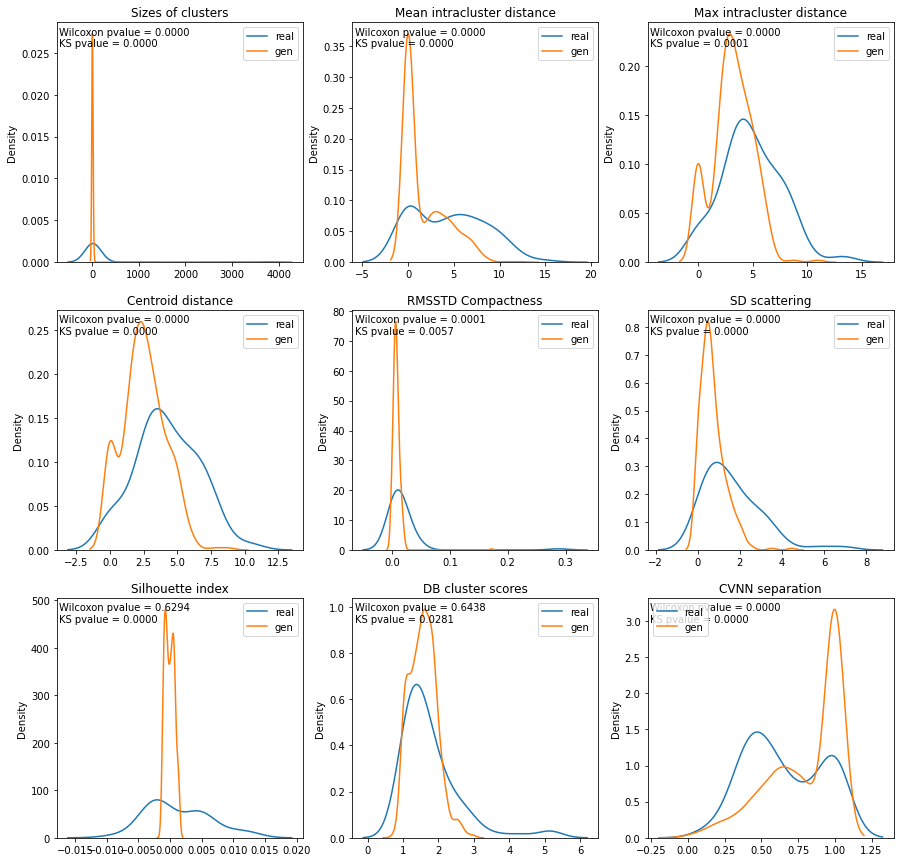

({'centroid_dist': RanksumsResult(statistic=5.650239797023867, pvalue=1.602241674563765e-08),
  'cvnn_sep': RanksumsResult(statistic=-4.753188185284148, pvalue=2.0023381475597205e-06),
  'db_score': RanksumsResult(statistic=0.46240806807466867, pvalue=0.6437887146319787),
  'max_dist': RanksumsResult(statistic=4.844740108586965, pvalue=1.2677751740970678e-06),
  'mean_dist': RanksumsResult(statistic=5.81553726772579, pvalue=6.043944550574584e-09),
  'rmsstd': RanksumsResult(statistic=3.854304267192611, pvalue=0.00011605918914133873),
  'sd_scat': RanksumsResult(statistic=5.626168742194484, pvalue=1.842561097311212e-08),
  'silhouette': RanksumsResult(statistic=-0.4825952943842081, pvalue=0.6293831209356555),
  'sizes': RanksumsResult(statistic=4.884773760925975, pvalue=1.0354768056621982e-06)},
 {'centroid_dist': Ks_2sampResult(statistic=0.37700509076937855, pvalue=7.242204038693245e-07),
  'cvnn_sep': Ks_2sampResult(statistic=0.29871967654986525, pvalue=3.320063146960983e-06),
  'db_s

In [178]:
run_all_stat_tests(ngram_series, labels, ngram_series_g, labels_g)

# Предобученный FastText

In [47]:
fasttext_vectors = gensim.downloader.load('fasttext-wiki-news-subwords-300')

KeyboardInterrupt: ignored

In [ ]:
preprocessing_funcs = [
    str.lower,
    strip_tags,
    strip_punctuation,
    strip_multiple_whitespaces,
    strip_numeric,
    # remove_stopwords,
]

words_in_data = []
embeddings = []
bad_words = []

for sentence in tqdm(sentences):
    words = preprocess_string(sentence, preprocessing_funcs)
    for word in words:
        try:
            embedding = fasttext_vectors.word_vec(word)
            embeddings.append(embedding)
            words_in_data.append(word)
        except KeyError:
            bad_words.append(word)
            # embeddings.append(fasttext_vectors.word_vec('token'))

In [ ]:
print('ratio of bad words', len(bad_words) / len(embeddings))

## Автоенкодер для FastText

In [ ]:
from keras.layers import InputLayer, Dense
from keras.models import Model, Sequential

INPUT_DIM = 300
OUTPUT_DIM = 40
ACTIVATION = 'tanh'

encoder = Sequential([
    InputLayer(input_shape=(INPUT_DIM,)),
    Dense(OUTPUT_DIM, activation=ACTIVATION)
])
decoder = Sequential([
    InputLayer(input_shape=(OUTPUT_DIM,)),
    Dense(INPUT_DIM, activation=None)
])
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

In [ ]:
train_words = words_in_data[10**6: 10**6 + 1_000_000]
train_embeddings = np.vstack(embeddings[10**6:10**6 + 1_000_000])

print(len(set(train_words)))
Counter(train_words).most_common(10)

In [ ]:
h = autoencoder.fit(train_embeddings, train_embeddings, batch_size=16, epochs=10, verbose=True, validation_split=0.1)

## Кластеризация сэмпла

# Свой word2vec (CBOW)